# 一、前期工作

今天的东西可能过于硬核！你准备好了吗？⏳

🔥本文 GitHub [https://github.com/kzbkzb/Python-AI](https://github.com/kzbkzb/Python-AI) 已收录

- 作者：[K同学啊](https://mp.weixin.qq.com/s/NES9RhtAhbX_jsmGua28dA)
- 来自专栏：《深度学习100例》-Tensorflow2版本
- 数据链接：https://pan.baidu.com/s/1Yw0ifbysm-z1nq7Gr4rW9Q （提取码：t4bk）

我的环境：

- 语言环境：Python3.6.5
- 编译器：jupyter notebook
- 深度学习环境：TensorFlow2.4.1

## 1. 设置GPU

如果使用的是CPU可以注释掉这部分的代码。

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")

if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)  #设置GPU显存用量按需使用
    tf.config.set_visible_devices([gpus[0]],"GPU")

# 打印显卡信息，确认GPU可用
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. 导入数据

In [2]:
import matplotlib.pyplot as plt
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

import os,PIL

# 设置随机种子尽可能使结果可以重现
import numpy as np
np.random.seed(1)

# 设置随机种子尽可能使结果可以重现
import tensorflow as tf
tf.random.set_seed(1)

import pathlib

In [3]:
data_dir = "D:/jupyter notebook/DL-100-days/datasets/016_Pokemon"

data_dir = pathlib.Path(data_dir)

## 3. 查看数据

In [4]:
image_count = len(list(data_dir.glob('*/*')))

print("图片总数为：",image_count)

图片总数为： 219


# 二、数据预处理

## 1. 加载数据

使用`image_dataset_from_directory`方法将磁盘中的数据加载到`tf.data.Dataset`中

In [5]:
batch_size = 8
img_height = 224
img_width = 224

TensorFlow版本是2.2.0的同学可能会遇到`module 'tensorflow.keras.preprocessing' has no attribute 'image_dataset_from_directory'`的报错，升级一下TensorFlow就OK了。

In [6]:
"""
关于image_dataset_from_directory()的详细介绍可以参考文章：https://mtyjkh.blog.csdn.net/article/details/117018789
"""
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 219 files belonging to 10 classes.
Using 176 files for training.


In [7]:
"""
关于image_dataset_from_directory()的详细介绍可以参考文章：https://mtyjkh.blog.csdn.net/article/details/117018789
"""
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 219 files belonging to 10 classes.
Using 43 files for validation.


我们可以通过class_names输出数据集的标签。标签将按字母顺序对应于目录名称。

In [8]:
class_names = train_ds.class_names
print(class_names)

['Alcremie', 'Eevee', 'Furfrou', 'Kyurem', 'Minior', 'Pikachu', 'Rotom', 'Squirtle', 'Vivillon', 'Zygarde']


## 2. 可视化数据

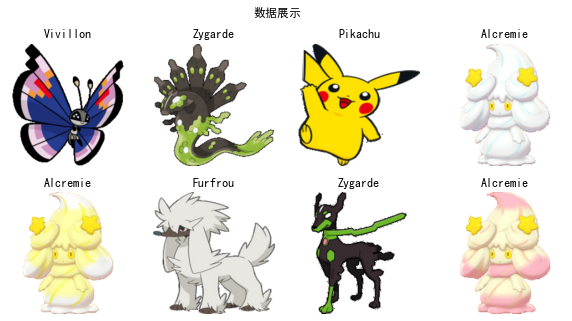

In [9]:
plt.figure(figsize=(10, 5))  # 图形的宽为10高为5
plt.suptitle("数据展示")

for images, labels in train_ds.take(1):
    for i in range(8):
        
        ax = plt.subplot(2, 4, i + 1)  
        
        ax.patch.set_facecolor('yellow')
        
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        
        plt.axis("off")

## 3. 再次检查数据 

In [10]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(8, 224, 224, 3)
(8,)


- `Image_batch`是形状的张量（8, 224, 224, 3)。这是一批形状240x240x3的8张图片（最后一维指的是彩色通道RGB）。 
- `Label_batch`是形状（8，）的张量，这些标签对应8张图片

## 4. 配置数据集

- **shuffle()** ： 打乱数据，关于此函数的详细介绍可以参考：https://zhuanlan.zhihu.com/p/42417456
- **prefetch()** ：预取数据，加速运行，其详细介绍可以参考我前两篇文章，里面都有讲解。
- **cache()** ：将数据集缓存到内存当中，加速运行

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 三、调用官方网络模型

前面给大家介绍了那么多模型，究竟哪一个模型更好呢？要不我们一 一手动复现+运行一下？NO，工作量太大了，咱头发也不够用啊

不知道你是否听说一个叫 `tf.keras.applications` 的神器，就是我前面用到的。

简单的讲 `tf.keras.applications` 就是它把我们常用的一些模型进行了封装，我如果想调用某一个模型时（例如：VGG-16），直接调用函数接口就OK了，而且还可以直接加载他们的预训练权重进行迁移学习（迁移学习：顾名思义就是就是把已学训练好的模型参数迁移到新的模型来帮助新模型训练。）

`tf.keras.applications` 目前支持的模型及该模型的性能参数如下（知道这么回事就好）：

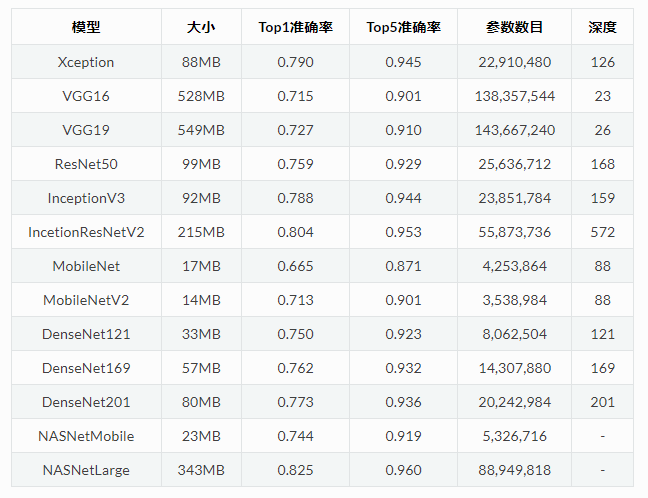

上述的参数来自 ILSVRC 大赛，使用的是 ImageNet 数据集。

`TOP-5正确率` 是什么意思：举个例子，我们要用训练好的网络进行分类任务，假设一共有50类图片，我们输入一张图片进行测试时，网络会依次输出该图片为这50个类别的概率。TOP-5正确率就是正确的标签（分类）在这5个类别里之中的概率。计算公式为：`所有测试图片中正确标签在前五个分类概率的个数` / `所有的测试图片数`（这部分内容了解即可）

`tf.keras.applications` API地址：https://www.tensorflow.org/api_docs/python/tf/keras/applications

**接口示例：VGG-16官方模型接口**

In [12]:
# 这是函数原型，请勿运行该代码
tf.keras.applications.vgg16.VGG16(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

常用的三个参数解释如下：

- include_top：是否包括网络顶部的 3 个全连接层。
- weights：默认不加载权重文件，`"imagenet" `加载官方权重文件，或者输入自己的权重文件路径。
- classes：分类图像的类别数

其他参数暂时不建议大家了解，模型接口都是非常相似的，大家可以从上面的众多模型中选择自己想要的调用，接口函数如下：

1. tf.keras.applications.xception.Xception()
2. tf.keras.applications.vgg16.VGG16()
3. tf.keras.applications.vgg19.VGG19()
4. tf.keras.applications.resnet50.ResNet50()
5. tf.keras.applications.inception_v3.InceptionV3()
6. tf.keras.applications.inception_resnet_v2.InceptionResNetV2()
7. tf.keras.applications.mobilenet.MobileNet()
8. tf.keras.applications.mobilenet_v2.MobileNetV2()
9. tf.keras.applications.densenet.DenseNet121()
10. tf.keras.applications.densenet.DenseNet169()
11. tf.keras.applications.densenet.DenseNet201()
12. tf.keras.applications.nasnet.NASNetMobile()
13. tf.keras.applications.nasnet.NASNetLarge()

In [13]:
"""
这里我使用 DenseNet121 模型
这一文章就先采用默认的1000类（classes=1000）
下一篇文章的时候我再讲解no-top与自定义类别数
"""
model = tf.keras.applications.DenseNet121(weights='imagenet')
model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

# 四、设置动态学习率

这里先罗列一下学习率大与学习率小的优缺点。

- 学习率大
    - 优点：
        1、加快学习速率。
        2、有助于跳出局部最优值。
    - 缺点：
        1、导致模型训练不收敛。
        2、单单使用大学习率容易导致模型不精确。

- 学习率小
    - 优点：
        1、有助于模型收敛、模型细化。
        2、提高模型精度。
    - 缺点：
        1、很难跳出局部最优值。
        2、收敛缓慢。

注意：这里设置的动态学习率为：指数衰减型（ExponentialDecay）。在每一个epoch开始前，学习率（learning_rate）都将会重置为初始学习率（initial_learning_rate），然后再重新开始衰减。计算公式如下：

>learning_rate = initial_learning_rate * decay_rate ^ (step / decay_steps)

In [14]:
# 设置初始学习率
initial_learning_rate = 1e-4

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, 
        decay_steps=5,      # 敲黑板！！！这里是指 steps，不是指epochs
        decay_rate=0.96,     # lr经过一次衰减就会变成 decay_rate*lr
        staircase=True)

# 将指数衰减学习率送入优化器
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# 五、编译

在准备对模型进行训练之前，还需要再对其进行一些设置。以下内容是在模型的编译步骤中添加的：

- 损失函数（loss）：用于衡量模型在训练期间的准确率。
- 优化器（optimizer）：决定模型如何根据其看到的数据和自身的损失函数进行更新。
- 指标（metrics）：用于监控训练和测试步骤。以下示例使用了准确率，即被正确分类的图像的比率。

In [15]:
model.compile(optimizer=optimizer,
              loss     ='sparse_categorical_crossentropy',
              metrics  =['accuracy'])

# 六、训练模型

In [16]:
epochs = 20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
22/22 [==============================] - 31s 158ms/step - loss: 3.9512 - accuracy: 0.4489 - val_loss: 3.3925 - val_accuracy: 0.3721
Epoch 2/20
22/22 [==============================] - 2s 77ms/step - loss: 0.1809 - accuracy: 0.9830 - val_loss: 1.9162 - val_accuracy: 0.6047
Epoch 3/20
22/22 [==============================] - 2s 77ms/step - loss: 0.0229 - accuracy: 1.0000 - val_loss: 1.1465 - val_accuracy: 0.7674
Epoch 4/20
22/22 [==============================] - 2s 76ms/step - loss: 0.0117 - accuracy: 1.0000 - val_loss: 0.8228 - val_accuracy: 0.8837
Epoch 5/20
22/22 [==============================] - 2s 76ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.6380 - val_accuracy: 0.9070
Epoch 6/20
22/22 [==============================] - 2s 77ms/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.5275 - val_accuracy: 0.9302
Epoch 7/20
22/22 [==============================] - 2s 79ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.4580 - val_accuracy: 0.9535
Epoch 8/20


# 七、模型评估

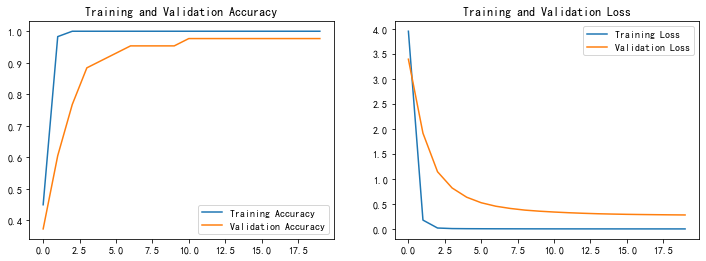

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 八、保存and加载模型

这是最简单的模型保存与加载方法哈

In [18]:
# 保存模型
model.save('model/16_model.h5')

In [19]:
# 加载模型
new_model = tf.keras.models.load_model('model/16_model.h5')

# 九、预测

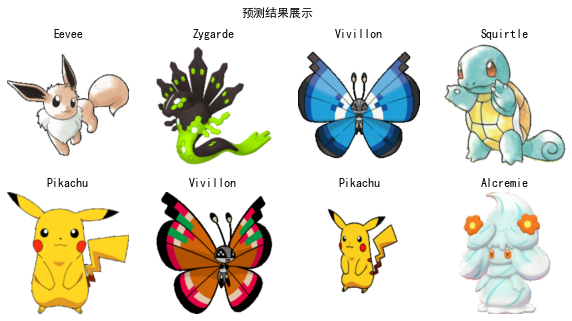

In [20]:
# 采用加载的模型（new_model）来看预测结果

plt.figure(figsize=(10, 5))  # 图形的宽为10高为5
plt.suptitle("预测结果展示")

for images, labels in val_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)  
        
        # 显示图片
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # 需要给图片增加一个维度
        img_array = tf.expand_dims(images[i], 0) 
        
        # 使用模型预测图片中的人物
        predictions = new_model.predict(img_array)
        plt.title(class_names[np.argmax(predictions)])

        plt.axis("off")